# 3 - VGG16 + small multi-layer perceptron

### Imports

In [12]:
%matplotlib inline

import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
# Dimensions of our images.
img_width, img_height = 224, 224

n_classes = 25
train_data_dir = '../data/train'
validation_data_dir = '../data/validation'

### Data preprocessing

In [3]:
# Pixel values rescaling from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

# Retrieve images and their classes for train and validation sets
train_generator_bottleneck = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

validation_generator_bottleneck = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 40805 images belonging to 25 classes.
Found 8856 images belonging to 25 classes.


### Loading the VGG 16 model

It is direclty available in Keras.

In [4]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

We use the VGG16 model to process our samples.

In [5]:
# bottleneck_features_train = model_vgg.predict_generator(train_generator_bottleneck, train_samples // batch_size)
# np.save(open('../models/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [6]:
# bottleneck_features_validation = model_vgg.predict_generator(validation_generator_bottleneck, validation_samples // batch_size)
# np.save(open('../models/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

We load the result.

In [7]:
num_classes = len(train_generator_bottleneck.class_indices)

train_data = np.load(open('../models/bottleneck_features_train.npy', 'rb'))
train_labels = to_categorical(train_generator_bottleneck.classes[:40773], num_classes=num_classes)

validation_data = np.load(open('../models/bottleneck_features_validation.npy', 'rb'))
validation_labels = to_categorical(validation_generator_bottleneck.classes[:8832], num_classes=num_classes)

We define and train a custom fully connected neural network.

In [8]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(512, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(n_classes, activation='softmax'))

In [9]:
model_top.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

In [15]:
epochs = 100
train_samples = 40800
validation_samples = 8832

In [16]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='../models/bottleneck_features.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model_top.fit(
        train_data,
        train_labels,
        verbose=2,
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[checkpointer, early_stopping],
        validation_data=(validation_data, validation_labels))

Train on 40773 samples, validate on 8832 samples
Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.85485, saving model to ../models/bottleneck_30_epochs.h5
10s - loss: 0.5774 - acc: 0.9388 - val_loss: 1.4095 - val_acc: 0.8548
Epoch 2/100
Epoch 00001: val_acc improved from 0.85485 to 0.85971, saving model to ../models/bottleneck_30_epochs.h5
10s - loss: 0.5847 - acc: 0.9376 - val_loss: 1.3789 - val_acc: 0.8597
Epoch 3/100
Epoch 00002: val_acc improved from 0.85971 to 0.86504, saving model to ../models/bottleneck_30_epochs.h5
10s - loss: 0.6157 - acc: 0.9377 - val_loss: 1.4269 - val_acc: 0.8650
Epoch 4/100
Epoch 00003: val_acc improved from 0.86504 to 0.86560, saving model to ../models/bottleneck_30_epochs.h5
10s - loss: 0.6148 - acc: 0.9388 - val_loss: 1.4024 - val_acc: 0.8656
Epoch 5/100
Epoch 00004: val_acc improved from 0.86560 to 0.86832, saving model to ../models/bottleneck_30_epochs.h5
10s - loss: 0.6104 - acc: 0.9397 - val_loss: 1.3745 - val_acc: 0.8683
Epoch 6/100
Epoch 0

### Evaluation on validation set

Computing loss and accuracy:

In [17]:
model_top.evaluate(validation_data, validation_labels)

8800/8832 [============================>.] - ETA: 0s

[1.596839298764293, 0.85880887681159424]

Learning curve:

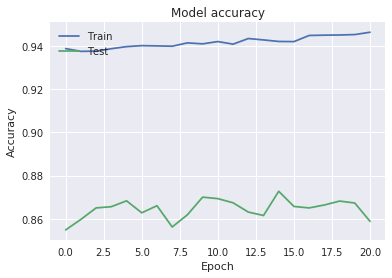

In [18]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig('../images/bottleneck_features.svg', format='svg', dpi=1200)

**We reached a 85% accuracy on the validation after ~10s of training (~1 epochs)!**

### Saving the model as JSON

In [20]:
with open('../models/bottleneck_features.json', 'w') as f:
    f.write(model_top.to_json())